In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir, load_yaml
from aimanager.utils.array_to_df import using_multiindex, add_labels
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

run = 'simple_9'

folder = f'../../data/manager_v3/{run}'

train_folder = os.path.join(folder, 'metrics')
merge_file = os.path.join(folder, 'metrics.parquet')
model_folder = os.path.join(folder, 'model')

plot_folder = f'plots/{run}'

make_dir(plot_folder)

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# if not os.path.isfile(merge_file):
#     dfs = [pd.read_parquet(os.path.join(train_folder, file)) for file in os.listdir(train_folder)]
#     df = pd.concat(dfs)
#     df.to_parquet(merge_file)
# else:
#     df = pd.read_parquet(merge_file)
dfs = [pd.read_parquet(os.path.join(train_folder, file)) for file in os.listdir(train_folder)]
df = pd.concat(dfs)

In [4]:
df.columns

Index(['artificial_humans', 'eps', 'gamma', 'lr', 'memory_episodes', 'model',
       'target_update_freq', 'job_id', 'round_number', 'sampling',
       'update_step', 'metric', 'value'],
      dtype='object')

In [5]:
non_labels = ['round_number', 'sampling', 'update_step', 'metric', 'value', 'job_id']

labels = [c for c in df.columns if c not in non_labels]


In [6]:
labels

['artificial_humans',
 'eps',
 'gamma',
 'lr',
 'memory_episodes',
 'model',
 'target_update_freq']

In [7]:
df['metric'].unique()

array(['punishments', 'contributions', 'common_good',
       'contributor_payoff', 'manager_payoff', 'next_reward', 'q_min',
       'q_max', 'q_mean', 'loss'], dtype=object)

In [8]:
import statsmodels.formula.api as smf
res = []
for ah in df['artificial_humans'].unique():
    for m in df['model'].unique():

        w = (
            (df['metric'] == 'common_good') &
            (df['sampling'] == 'greedy')&
            (df['artificial_humans'] == ah)&
            (df['model'] == m)
        )
        dfs = df[w].copy()
        w_max = (dfs['update_step'] > (0.8 * dfs['update_step'].max()))
        dfs = dfs[w_max].copy()

        for l in labels:
            dfs[l] = dfs[l].astype(str)


        label_ref = {
            'eps': '0.1',
            'gamma': '1.0',
            'lr': '3.e-4',
            'memory_episodes': '100',
            'target_update_freq': '100',
        }


        label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]


        results = smf.glm(f"value ~ {'+'.join(label_str)}", data=dfs).fit()
        results_df = results.summary2().tables[1]
        results_df['artificial_humans'] = ah
        results_df['model'] = m
        res.append(results_df)
        # print('metric accuracy - positive coef -> better')
        # results_df[results_df['P>|z|'] < 0.25].sort_values('P>|z|')
        # print(f'{ah} | {m}')
        # print(results_df)
results_df = pd.concat(res)


results_df = results_df.reset_index()
results_df

index      Coef.  Std.Err.  \
0                                           Intercept  22.320687  0.080141   
1           C(eps, Treatment(reference='0.1'))[T.0.2]  -0.207707  0.060581   
2         C(gamma, Treatment(reference='1.0'))[T.0.5]   0.152464  0.074197   
3         C(gamma, Treatment(reference='1.0'))[T.0.8]   0.433002  0.074197   
4        C(lr, Treatment(reference='3.e-4'))[T.1.e-4]  -0.078128  0.060581   
5   C(memory_episodes, Treatment(reference='100'))...  -0.032788  0.060581   
6   C(target_update_freq, Treatment(reference='100...  -0.009951  0.060581   
7                                           Intercept  22.395601  0.078296   
8           C(eps, Treatment(reference='0.1'))[T.0.2]  -0.190804  0.059186   
9         C(gamma, Treatment(reference='1.0'))[T.0.5]  -0.061808  0.072488   
10        C(gamma, Treatment(reference='1.0'))[T.0.8]  -0.079611  0.072488   
11       C(lr, Treatment(reference='3.e-4'))[T.1.e-4]   0.165659  0.059186   
12  C(memory_episodes, Treatment(reference='100'))...   0.132697  0.059186   
13  C(target_update_freq, Treatment(reference='100...  -0.134892  0.059186   
14                                          Intercept  22.011485  0.079987   
15          C(eps, Treatment(reference='0.1'))[T.0.2]   0.433513  0.061198   
16        C(gamma, Treatment(reference='1.0'))[T.0.5]   0.245258  0.075396   
17        C(gamma, Treatment(reference='1.0'))[T.0.8]   0.190310  0.074054   
18       C(lr, Treatment(reference='3.e-4'))[T.1.e-4]  -0.019121  0.061198   
19  C(memory_episodes, Treatment(reference='100'))...   0.153964  0.061198   
20  C(target_update_freq, Treatment(reference='100...  -0.410134  0.061198   
21                                          Intercept  23.562247  0.077608   
22          C(eps, Treatment(reference='0.1'))[T.0.2]  -0.455272  0.058666   
23        C(gamma, Treatment(reference='1.0'))[T.0.5]   0.189818  0.071851   
24        C(gamma, Treatment(reference='1.0'))[T.0.8]   0.036401  0.071851   
25       C(lr, Treatment(reference='3.e-4'))[T.1.e-4]  -0.002374  0.058666   
26  C(memory_episodes, Treatment(reference='100'))...   0.110939  0.058666   
27  C(target_update_freq, Treatment(reference='100...  -0.078916  0.058666   
28                                          Intercept  23.412753  0.076498   
29          C(eps, Treatment(reference='0.1'))[T.0.2]   0.291648  0.057827   
30        C(gamma, Treatment(reference='1.0'))[T.0.5]  -0.154904  0.070823   
31        C(gamma, Treatment(reference='1.0'))[T.0.8]  -0.209209  0.070823   
32       C(lr, Treatment(reference='3.e-4'))[T.1.e-4]   0.015036  0.057827   
33  C(memory_episodes, Treatment(reference='100'))...   0.019286  0.057827   
34  C(target_update_freq, Treatment(reference='100...  -0.008870  0.057827   
35                                          Intercept  22.956804  0.076031   
36          C(eps, Treatment(reference='0.1'))[T.0.2]   0.647665  0.057474   
37        C(gamma, Treatment(reference='1.0'))[T.0.5]  -0.179668  0.070391   
38        C(gamma, Treatment(reference='1.0'))[T.0.8]   0.335270  0.070391   
39       C(lr, Treatment(reference='3.e-4'))[T.1.e-4]  -0.157676  0.057474   
40  C(memory_episodes, Treatment(reference='100'))...  -0.140330  0.057474   
41  C(target_update_freq, Treatment(reference='100...   0.028475  0.057474   

             z         P>|z|     [0.025     0.975] artificial_humans     model  
0   278.516131  0.000000e+00  22.163612  22.477761            simple  rnn_edge  
1    -3.428567  6.067772e-04  -0.326444  -0.088970            simple  rnn_edge  
2     2.054862  3.989236e-02   0.007041   0.297886            simple  rnn_edge  
3     5.835873  5.350973e-09   0.287579   0.578424            simple  rnn_edge  
4    -1.289637  1.971768e-01  -0.196865   0.040609            simple  rnn_edge  
5    -0.541217  5.883583e-01  -0.151525   0.085949            simple  rnn_edge  
6    -0.164263  8.695243e-01  -0.128688   0.108786            simple  rnn_edge  
7   286.036868  0.000000e+00  22.242143  22.5

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


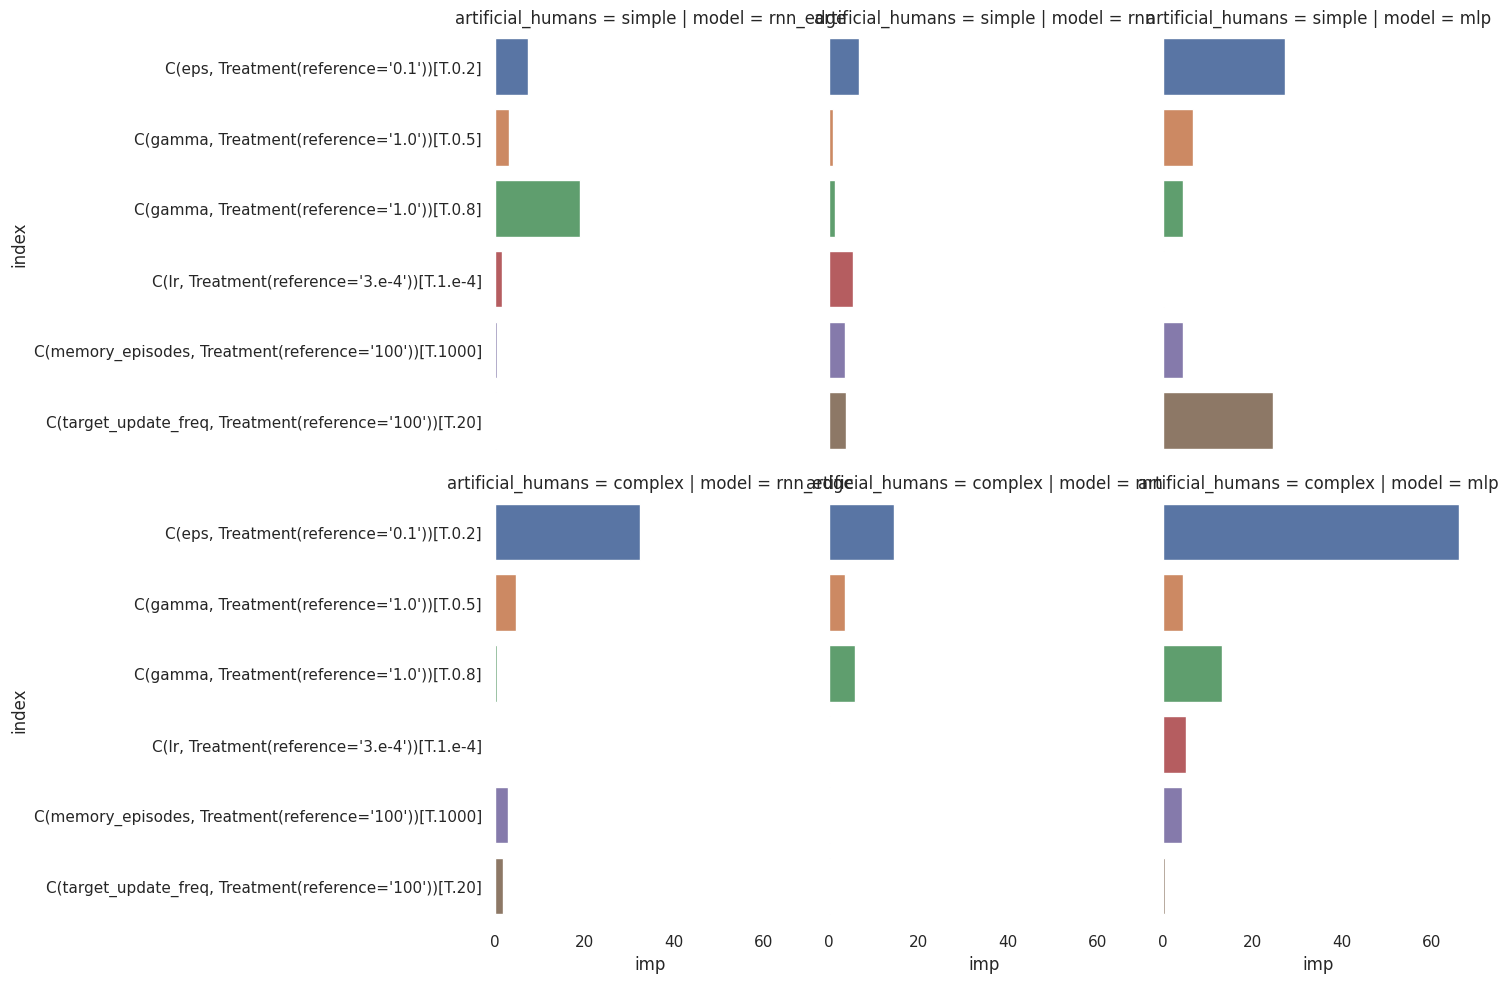

In [26]:
results_df['imp'] = - np.log(results_df['P>|z|'])

sns.catplot(data=results_df[results_df['index'] != 'Intercept'], x='imp', y='index', col='model', row='artificial_humans', kind='bar')

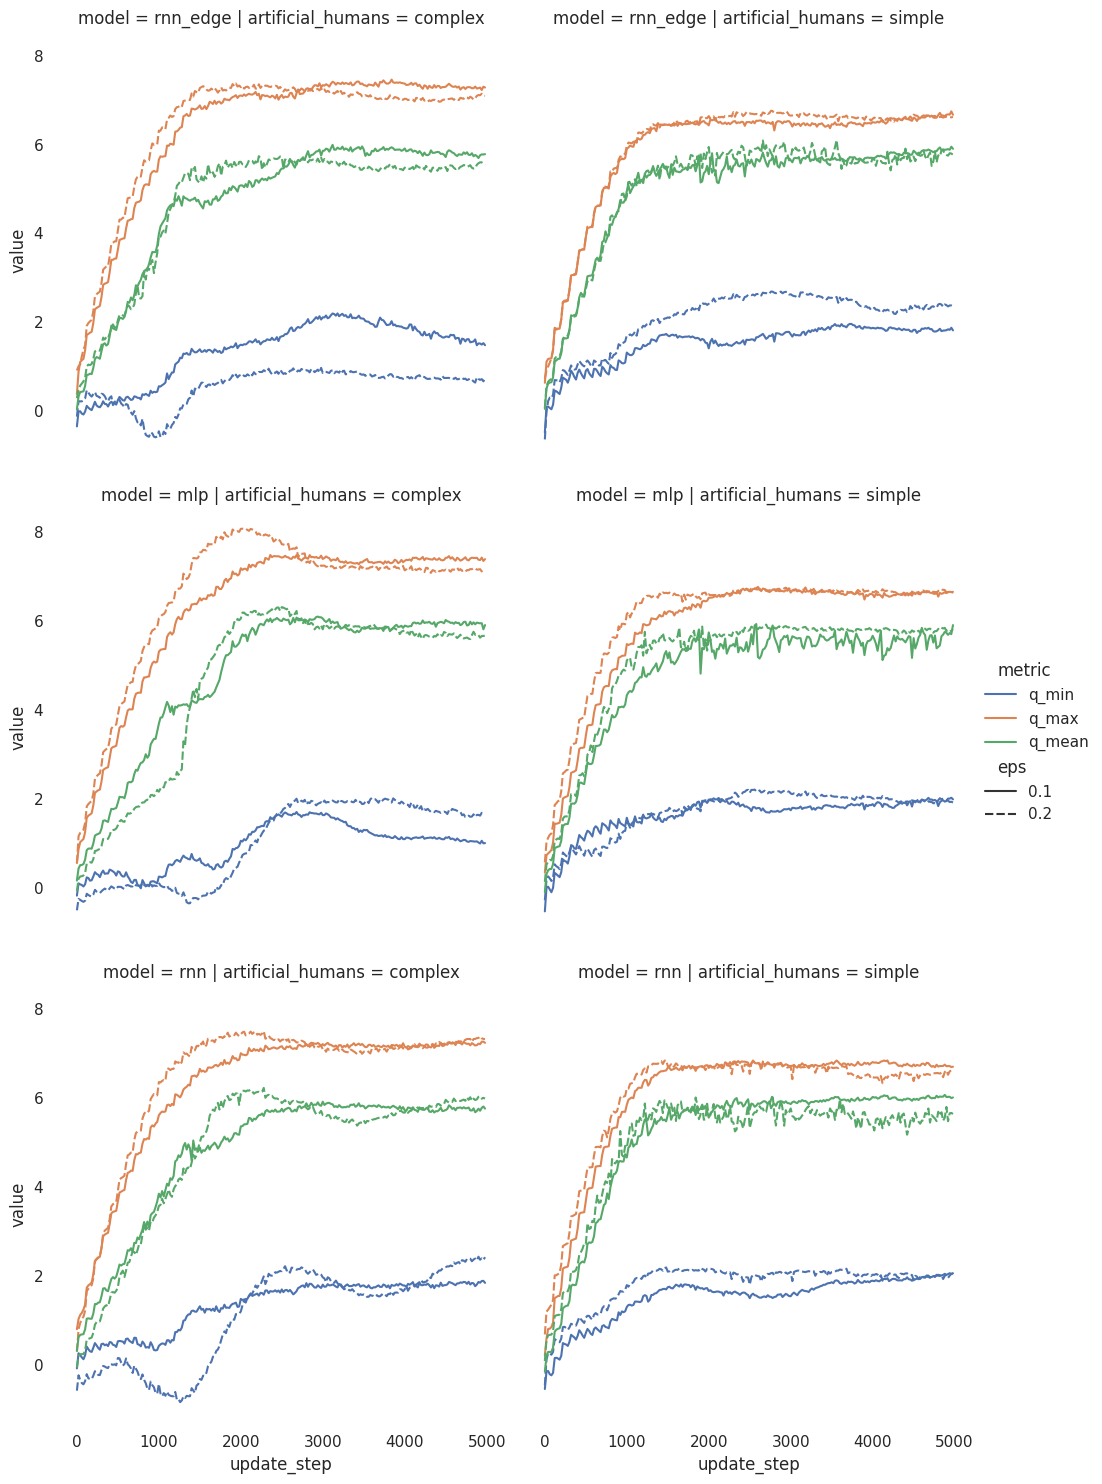

In [27]:
selection = {'eps': 0.2, 'gamma': 1, 'lr': '3.e-4', 'metric': 'next_reward', 'memory_episodes': 100, 'sampling': 'greedy', 'target_update_freq': 20}

focus = ['update_step', 'metric', 'eps', 'artificial_humans', 'model']

# selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['q_min', 'q_max', 'q_mean'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)


fg.savefig(os.path.join(plot_folder, 'q_values.jpg'))

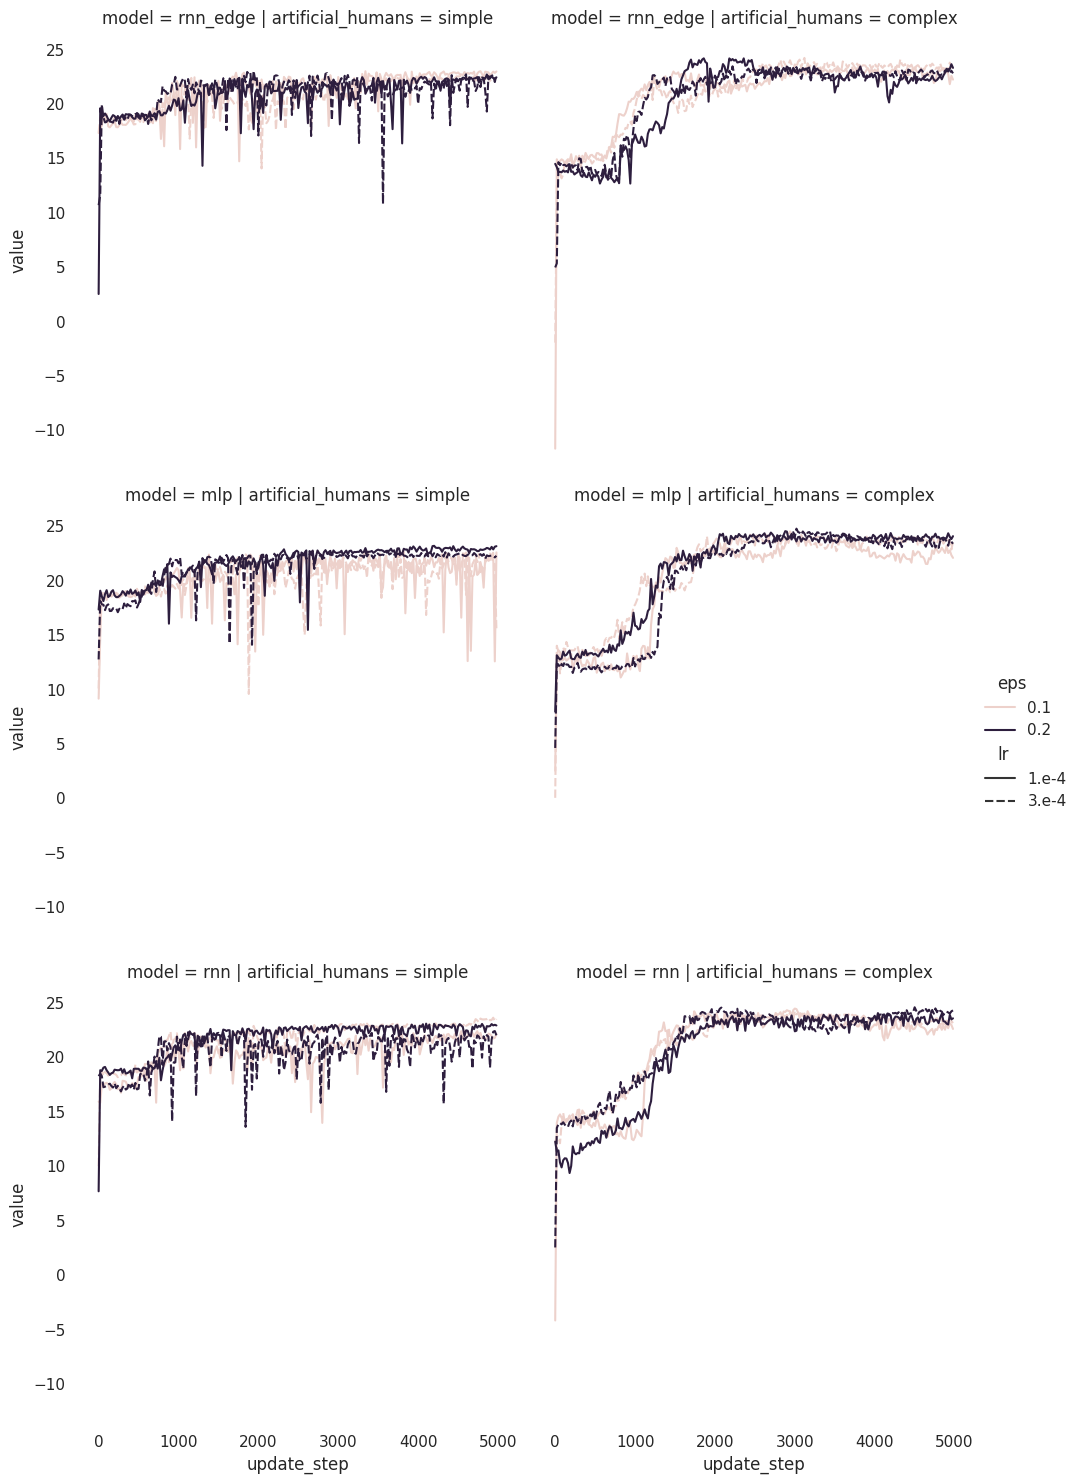

In [28]:
selection = {'eps': 0.2, 'gamma': 1, 'lr': '3.e-4', 'metric': 'common_good', 'memory_episodes': 100, 'sampling': 'greedy', 'target_update_freq': 20}

focus = ['update_step', 'eps', 'lr','artificial_humans', 'model']

# selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['contributions', 'punishments', 'common_good'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)


fg.savefig(os.path.join(plot_folder, 'q_values.jpg'))

<AxesSubplot:xlabel='artificial_humans', ylabel='value'>

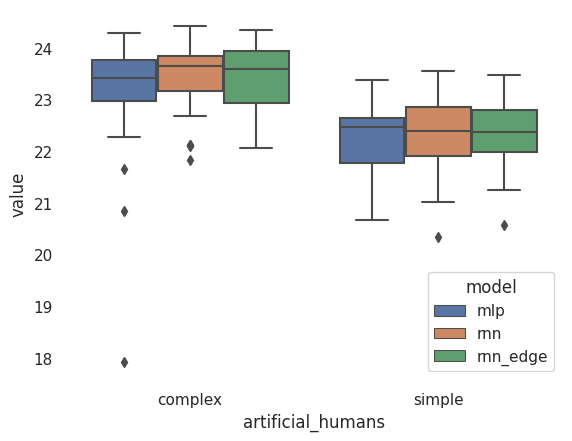

In [32]:
w = (
    (df['metric'] == 'common_good') &
    (df['sampling'] == 'greedy')
)
dfs = df[w].copy()
w_max = (dfs['update_step'] > (0.8 * dfs['update_step'].max()))
dfs = dfs[w_max].copy()

dfs = dfs.groupby(labels)['value'].mean().reset_index()

sns.boxplot(data=dfs, y='value', hue='model', x='artificial_humans')

In [30]:
dfs[labels]

artificial_humans  eps  gamma     lr  memory_episodes     model  \
22416            simple  0.1    1.0  3.e-4             1000  rnn_edge   
22417            simple  0.1    1.0  3.e-4             1000  rnn_edge   
22418            simple  0.1    1.0  3.e-4             1000  rnn_edge   
22419            simple  0.1    1.0  3.e-4             1000  rnn_edge   
22420            simple  0.1    1.0  3.e-4             1000  rnn_edge   
...                 ...  ...    ...    ...              ...       ...   
23995            simple  0.2    1.0  1.e-4              100       mlp   
23996            simple  0.2    1.0  1.e-4              100       mlp   
23997            simple  0.2    1.0  1.e-4              100       mlp   
23998            simple  0.2    1.0  1.e-4              100       mlp   
23999            simple  0.2    1.0  1.e-4              100       mlp   

       target_update_freq  
22416                  20  
22417                  20  
22418                  20  
22419                  20  
22420                  20  
...                   ...  
23995                 100  
23996                 100  
23997                 100  
23998                 100  
23999                 100  

[229600 rows x 7 columns]

<AxesSubplot:xlabel='artificial_humans', ylabel='value'>

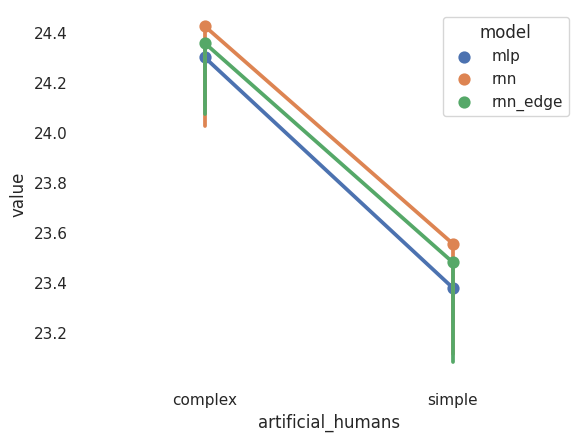

In [33]:
dfs


sns.pointplot(data=dfs, y='value', hue='model', x='artificial_humans', estimator=np.max)

In [23]:
dfs

artificial_humans  eps  gamma     lr  memory_episodes     model  \
22416            simple  0.1    1.0  3.e-4             1000  rnn_edge   
22417            simple  0.1    1.0  3.e-4             1000  rnn_edge   
22418            simple  0.1    1.0  3.e-4             1000  rnn_edge   
22419            simple  0.1    1.0  3.e-4             1000  rnn_edge   
22420            simple  0.1    1.0  3.e-4             1000  rnn_edge   
...                 ...  ...    ...    ...              ...       ...   
23995            simple  0.2    1.0  1.e-4              100       mlp   
23996            simple  0.2    1.0  1.e-4              100       mlp   
23997            simple  0.2    1.0  1.e-4              100       mlp   
23998            simple  0.2    1.0  1.e-4              100       mlp   
23999            simple  0.2    1.0  1.e-4              100       mlp   

       target_update_freq                                             job_id  \
22416                  20  model_rnn_edge__artificial_humans_simple__memo...   
22417                  20  model_rnn_edge__artificial_humans_simple__memo...   
22418                  20  model_rnn_edge__artificial_humans_simple__memo...   
22419                  20  model_rnn_edge__artificial_humans_simple__memo...   
22420                  20  model_rnn_edge__artificial_humans_simple__memo...   
...                   ...                                                ...   
23995                 100  model_mlp__artificial_humans_simple__memory_ep...   
23996                 100  model_mlp__artificial_humans_simple__memory_ep...   
23997                 100  model_mlp__artificial_humans_simple__memory_ep...   
23998                 100  model_mlp__artificial_humans_simple__memory_ep...   
23999                 100  model_mlp__artificial_humans_simple__memory_ep...   

       round_number sampling  update_step       metric      value  
22416             0   greedy         4000  common_good   7.912901  
22417             1   greedy         4000  common_good  12.950351  
22418             2   greedy         4000  common_good  17.836651  
22419             3   greedy         4000  common_good  20.812450  
22420             4   greedy         4000  common_good  22.485500  
...             ...      ...          ...          ...        ...  
23995            11   greedy         4980  common_good  25.812252  
23996            12   greedy         4980  common_good  25.646603  
23997            13   greedy         4980  common_good  25.772852  
23998            14   greedy         4980  common_good  25.986353  
23999            15   greedy         4980  common_good  24.664001  

[229600 rows x 13 columns]

In [ ]:
results_df[results_df['P>|z|'] < 0.25].sort_values('P>|z|')
results_df

In [8]:
df['target_update_freq'].unique()

array([100,  20])

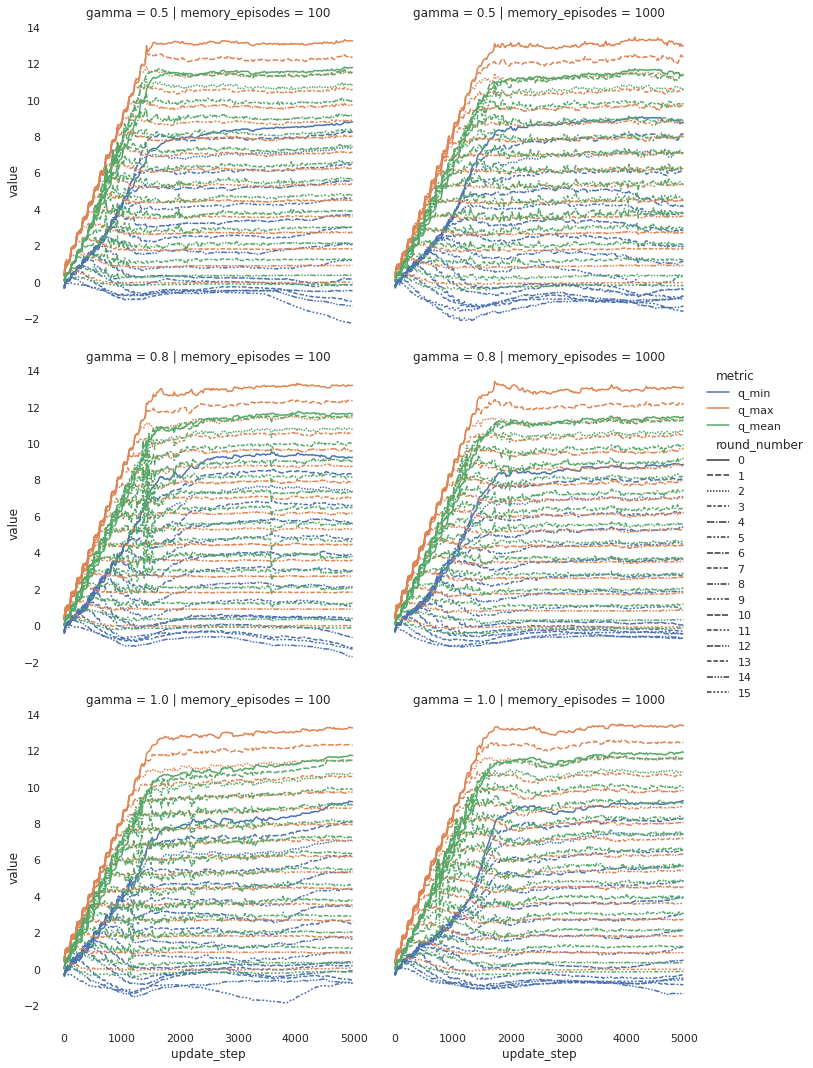

In [9]:
selection = {'eps': 0.2, 'gamma': 0.5, 'lr': '1.e-4', 'metric': 'next_reward', 'memory_episodes': 100, 'sampling': 'greedy', 'target_update_freq': 20}

focus = ['update_step', 'metric', 'round_number', 'memory_episodes', 'gamma']

# selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['q_min', 'q_max', 'q_mean'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)


fg.savefig(os.path.join(plot_folder, 'q_values.jpg'))

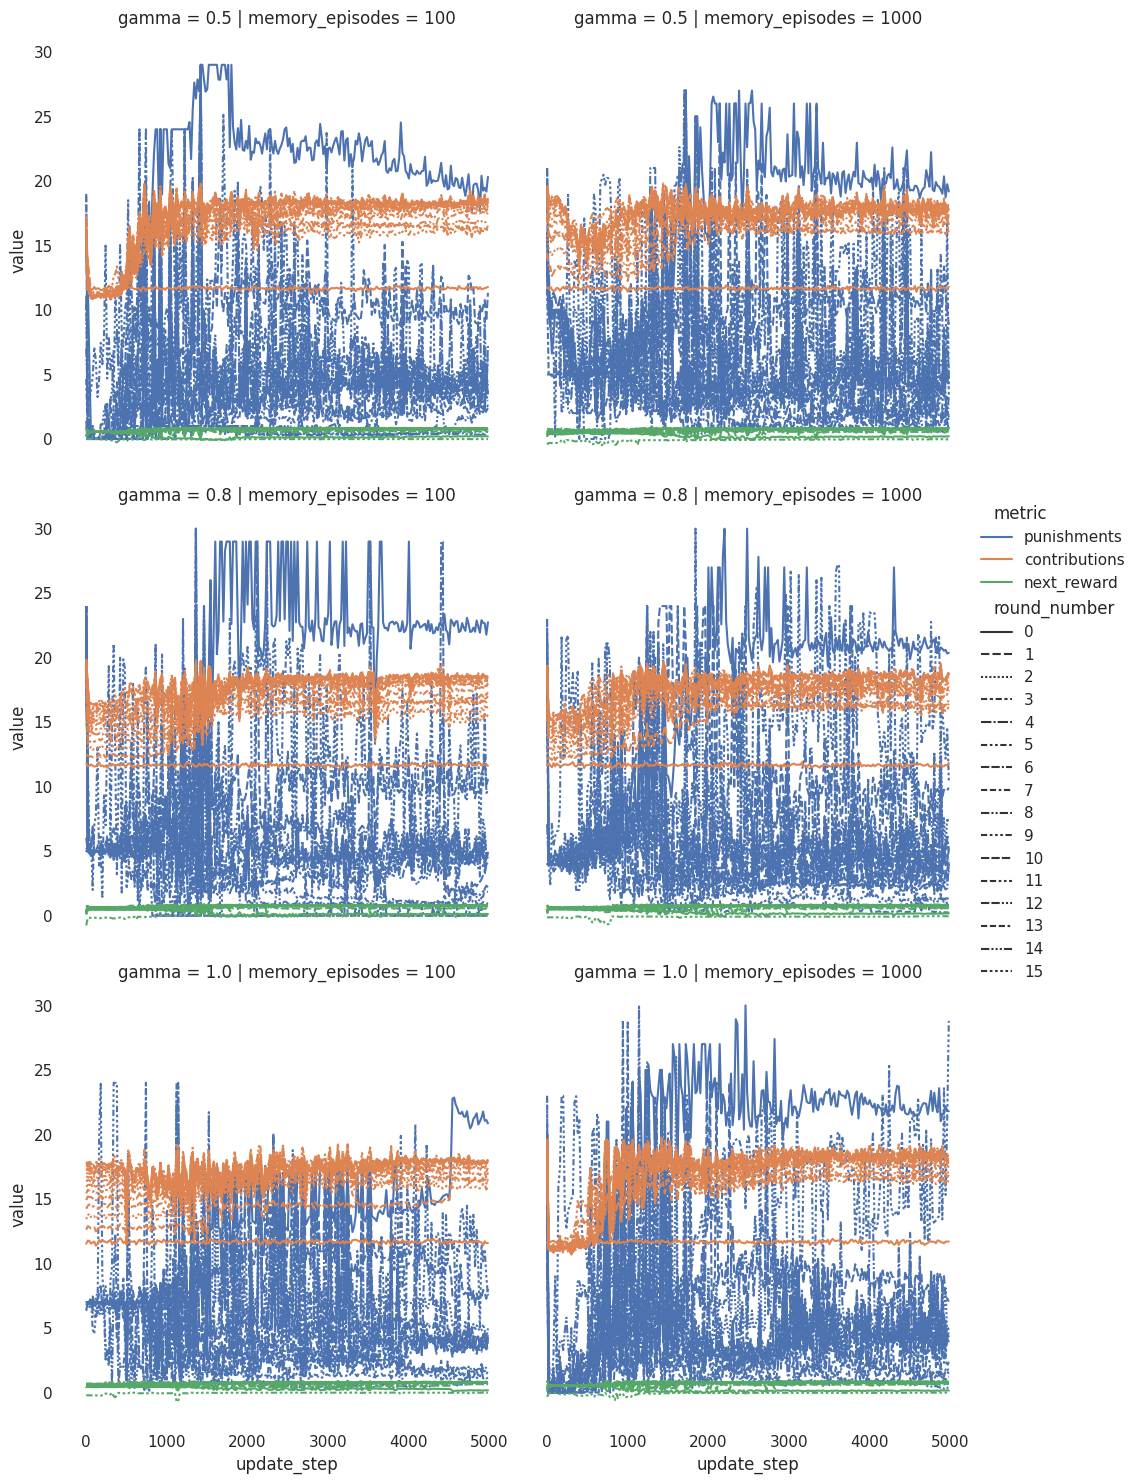

In [10]:
focus = ['update_step', 'metric', 'round_number', 'memory_episodes', 'gamma']

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['contributions', 'punishments', 'next_reward'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)

fg.savefig(os.path.join(plot_folder, 'metrics.jpg'))


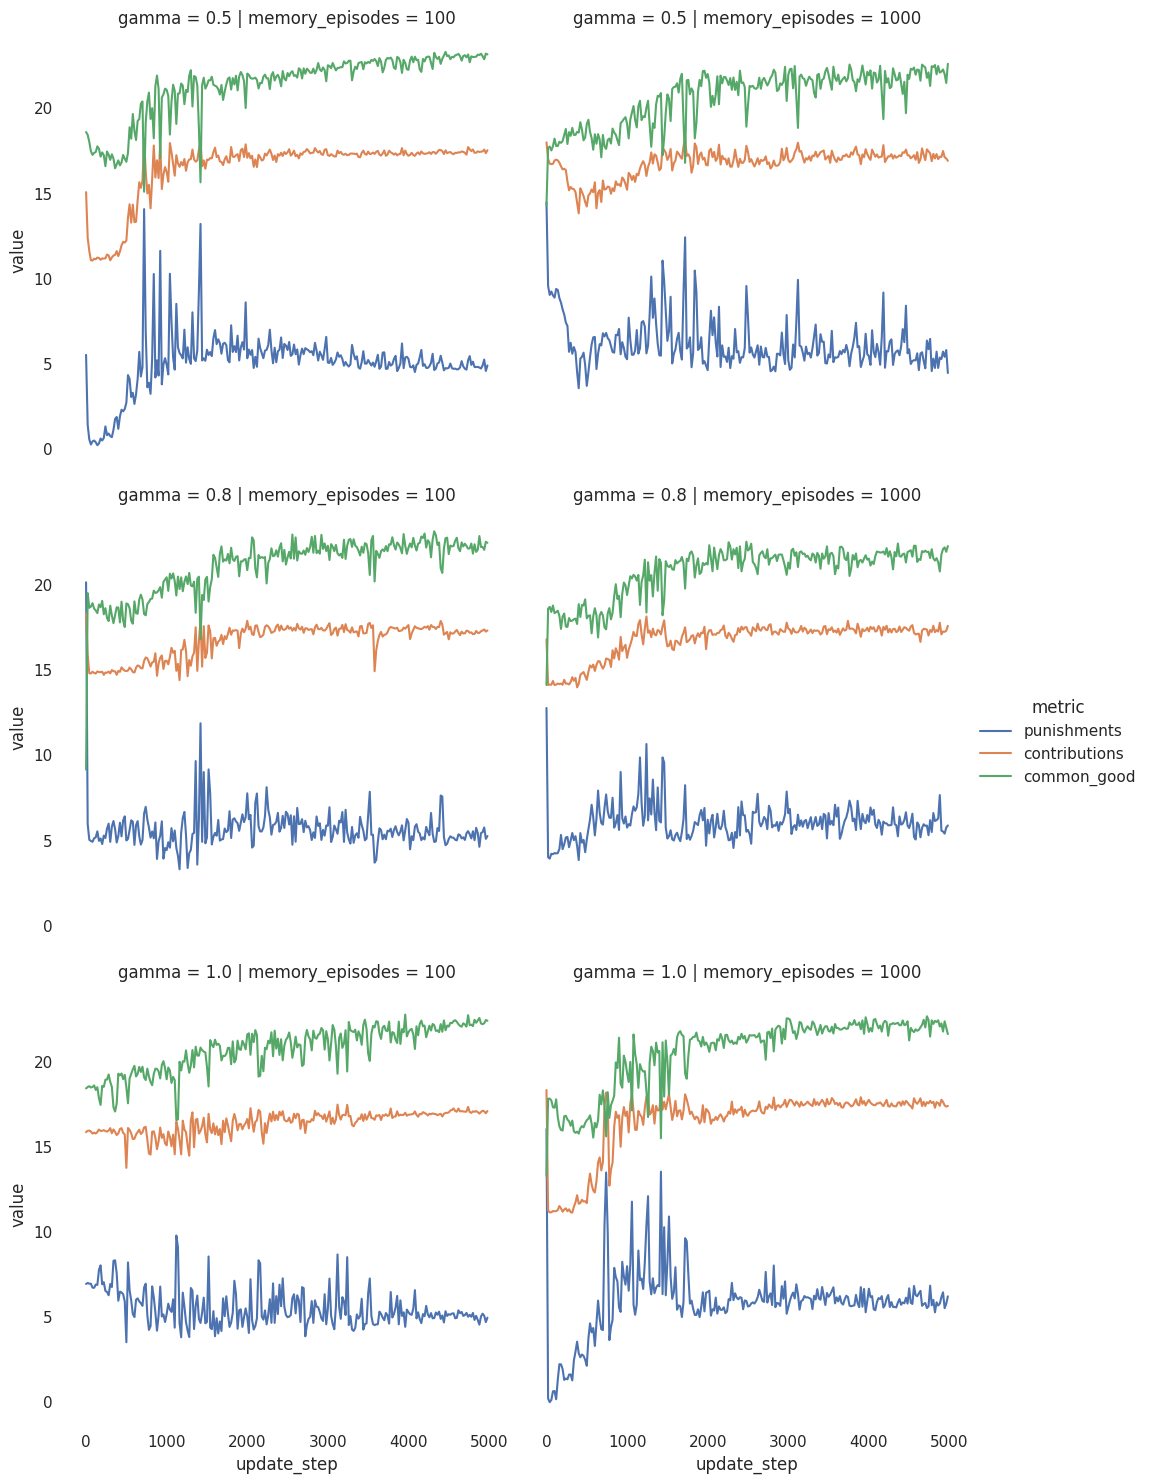

In [11]:
focus = ['update_step', 'metric', 'memory_episodes', 'gamma']

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['contributions', 'punishments', 'common_good'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='line', ci=None)

fg.savefig(os.path.join(plot_folder, 'metrics.jpg'))

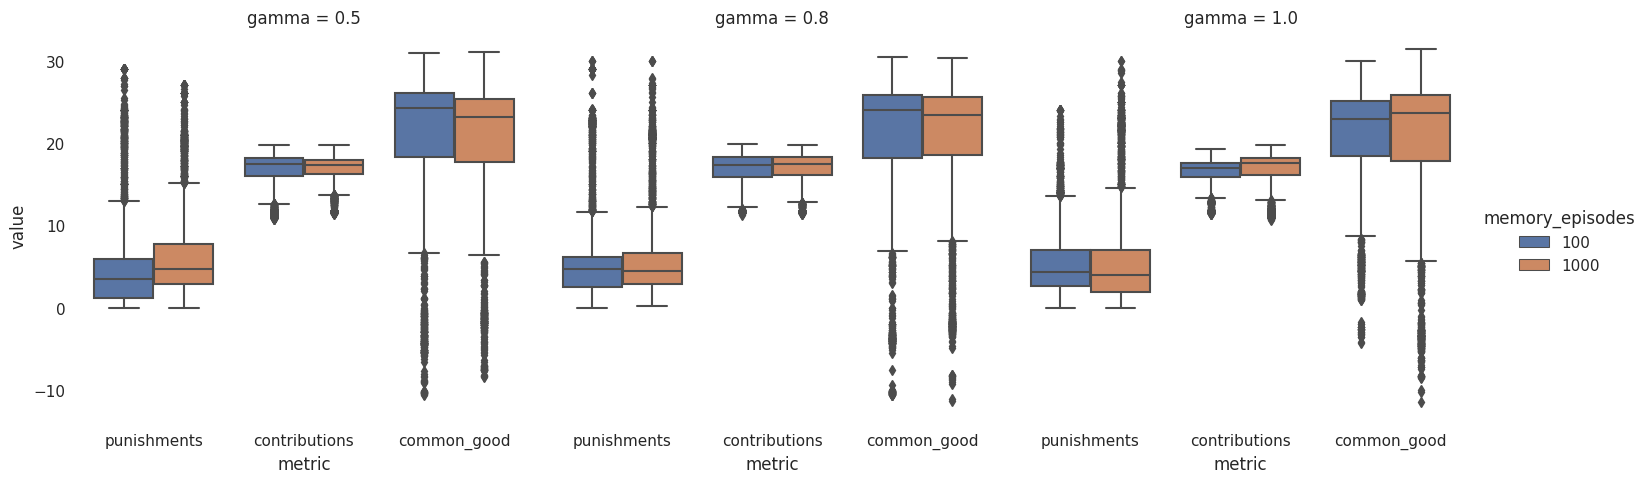

In [12]:
focus = ['metric', 'memory_episodes', 'gamma']

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()


# dfs = dfs[dfs['update_step'] > 4000]

w = dfs['metric'].isin(['contributions', 'punishments', 'common_good'])
dfs = dfs[w]


fg = sns.catplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='box', ci=None)

fg.savefig(os.path.join(plot_folder, 'metrics.jpg'))

In [13]:
import os
import torch as th
import numpy as np
import pandas as pd
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.environment_v3 import ArtificialHumanEnv
from aimanager.manager.manager import ArtificalManager

device = th.device('cpu')

n_episodes = 1000

class RuleHuman():
    def __init__(self, contribution):
        self.contribution = contribution

    def encode_pure(self, data, **kwargs):
        return data

    def predict_pure(self, data, **kwargs):
        return th.full_like(data['prev_contributions'], fill_value=self.contribution), 


job_id = df.iloc[0]['job_id']
model_file = os.path.join(model_folder, f'{job_id}.parquet')
rec_keys = ['punishments', 'contributions', 'common_good', 'contributor_payoff', 'manager_payoff']
metric_list = []

for c in range(0,20):
    human_rule_args = {
        'contribution': c
    }

    ah = RuleHuman(**human_rule_args)
    manager = ArtificalManager.load(model_file, device=device)
    env = ArtificialHumanEnv(
        artifical_humans=ah, default_values=manager.default_values, n_agents=4, n_contributions=21, n_punishments=31, batch_size=n_episodes, n_rounds=16, device=device)

    state = env.reset()
    for round_number in count():
        action = manager.get_punishment(**state, **env.get_batch_structure())
        state = env.punish(action)
        
        metrics = {
            k: state[k].to(th.float).mean().item() for k in rec_keys}
        
        metrics = {**metrics, **human_rule_args, 'manager': job_id}

        # pass actions to environment and advance by one step
        state, reward, done = env.step()

        metrics['next_reward'] = reward.mean().item()
        metrics['round_number'] = round_number
        metric_list.append(metrics)
        # break
        if done:
            break

# df.to_parquet(os.path.join(output_path, f'metrics.parquet'))

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


AttributeError: 'GraphNetwork' object has no attribute 'bias_encoder'

In [ ]:
id_vars = ['round_number', 'manager'] + list(human_rule_args.keys())

dfm = pd.DataFrame.from_records(metric_list)

value_vars = list(set(dfm.columns) - set(id_vars))
dfm = dfm.melt(id_vars=id_vars, value_vars=value_vars, var_name='metric')

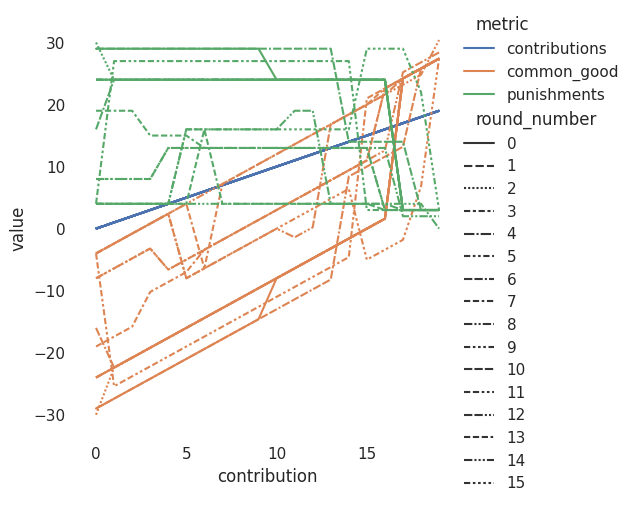

In [ ]:
selection = {}

focus = ['contribution', 'metric', 'round_number']

dfs = dfm.copy()

if len(selection):
    w = pd.concat(
        (dfs[k] == v
        for k,v in selection.items() if (k not in focus) and (k in dfs.columns)
        ), axis=1
    ).all(1)
    dfs = dfs[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['contributions', 'punishments', 'common_good'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)

fg.savefig(os.path.join(plot_folder, 'metrics.jpg'))

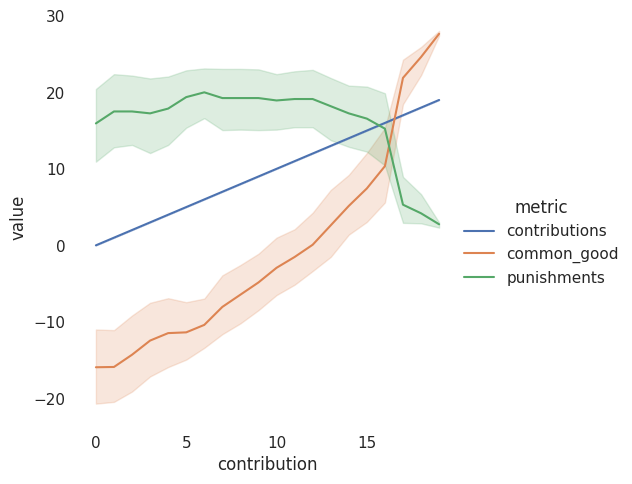

In [ ]:
selection = {}

focus = ['contribution', 'metric']

dfs = dfm.copy()

if len(selection):
    w = pd.concat(
        (dfs[k] == v
        for k,v in selection.items() if (k not in focus) and (k in dfs.columns)
        ), axis=1
    ).all(1)
    dfs = dfs[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['contributions', 'punishments', 'common_good'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line')

fg.savefig(os.path.join(plot_folder, 'metrics.jpg'))